In [2]:
!pip install torchinfo

- https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/aae/aae.py

In [34]:
import torch
from torch import nn,optim
# from torch.utils.data import Datasets

from torch.utils.data import DataLoader
from torchvision import datasets,transforms

from torchinfo import summary
import numpy as np
torch.__version__

'1.9.0+cu102'

In [4]:
import matplotlib.pyplot as plt

## Setting up the devices

In [5]:
available_device= "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(available_device)
print(device)

cuda


## Loading the MNIST Dataset

### Dataset

In [6]:
train_set = datasets.MNIST(root="pytorch_dataset/",
                           train=True,
                           download=True,
                           transform=transforms.ToTensor())
                           
test_set = datasets.MNIST(root="pytorch_dataset/",
                          train=False,
                          download=True,
                          transform=transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting pytorch_dataset/MNIST/raw/train-images-idx3-ubyte.gz to pytorch_dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting pytorch_dataset/MNIST/raw/train-labels-idx1-ubyte.gz to pytorch_dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting pytorch_dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to pytorch_dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting pytorch_dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to pytorch_dataset/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Dataloader

In [7]:
BATCH_SIZE = 64

train_loader = DataLoader(dataset=train_set,
                          batch_size=BATCH_SIZE,
                          shuffle=True)
test_loader = DataLoader(dataset=test_set,
                         batch_size=BATCH_SIZE,
                         shuffle=True)
print("Data loaded")

Data loaded


In [8]:
for x, y in train_loader:
  print(x.shape)
  print(y.shape)
  break

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [9]:
def show_grid_tensor(grid_im, n, c=None):
    fig = plt.figure(figsize=(15,15))
    for i in range(n):
        ax = plt.subplot(8, 8, i+1)
        plt.imshow(grid_im[i], cmap=c)
        plt.axis("off")
        # ax.set_title(f"activation {i}")
    return plt

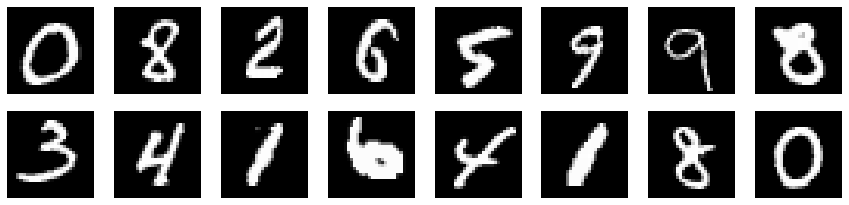

In [10]:
# x shape = [N, channels, H, W]
# view_batch shape = [N, H, W, channels]
view_batch = x.permute(0, 2, 3, 1)
ax1 = show_grid_tensor(view_batch.squeeze(), 16, c='gray')
ax1.show()

In [11]:
### Dummy x 
dummy_x = torch.randn([64,784])
dummy_x.shape

torch.Size([64, 784])

## Encoder

In [12]:
class Encoder(nn.Module):

    def __init__(self, latent_dim=10):
        super(Encoder, self).__init__()

        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, latent_dim)
        self.relu = nn.ReLU()

    def forward(self,x):
        
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        latent_var = self.fc3(x)
        return latent_var 


In [13]:
e = Encoder(latent_dim=2)
summary(e, (64,784))
# l = e(dummy_x)
# l.shape

Layer (type:depth-idx)                   Output Shape              Param #
Encoder                                  --                        --
├─Linear: 1-1                            [64, 512]                 401,920
├─ReLU: 1-2                              [64, 512]                 --
├─Linear: 1-3                            [64, 512]                 262,656
├─ReLU: 1-4                              [64, 512]                 --
├─Linear: 1-5                            [64, 2]                   1,026
Total params: 665,602
Trainable params: 665,602
Non-trainable params: 0
Total mult-adds (M): 42.60
Input size (MB): 0.20
Forward/backward pass size (MB): 0.53
Params size (MB): 2.66
Estimated Total Size (MB): 3.39

## Decoder

In [14]:
class Decoder(nn.Module):

    def __init__(self, latent_dim=10):
        super(Decoder, self).__init__()

        self.fc1 = nn.Linear(latent_dim, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 784)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, latent_var):
        
        decoded_x = self.relu(self.fc1(latent_var))
        decoded_x = self.relu(self.fc2(decoded_x))
        decoded_x = self.sigmoid(self.fc3(decoded_x))
        return decoded_x 

In [15]:
d = Decoder(latent_dim=2)

summary(d, (64,2))

Layer (type:depth-idx)                   Output Shape              Param #
Decoder                                  --                        --
├─Linear: 1-1                            [64, 512]                 1,536
├─ReLU: 1-2                              [64, 512]                 --
├─Linear: 1-3                            [64, 512]                 262,656
├─ReLU: 1-4                              [64, 512]                 --
├─Linear: 1-5                            [64, 784]                 402,192
├─Sigmoid: 1-6                           [64, 784]                 --
Total params: 666,384
Trainable params: 666,384
Non-trainable params: 0
Total mult-adds (M): 42.65
Input size (MB): 0.00
Forward/backward pass size (MB): 0.93
Params size (MB): 2.67
Estimated Total Size (MB): 3.59

## Discriminator

In [16]:
class Discriminator(nn.Module):

    def __init__(self, latent_dim=10):
        super(Discriminator, self).__init__()

        self.fc1 = nn.Linear(latent_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, latent_var):
        
        pred = self.relu(self.fc1(latent_var))
        pred = self.relu(self.fc2(pred))
        pred = self.sigmoid(self.fc3(pred))
        return pred 

In [17]:
dis = Discriminator(latent_dim=2)
summary(dis, (64,2))

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            --                        --
├─Linear: 1-1                            [64, 512]                 1,536
├─ReLU: 1-2                              [64, 512]                 --
├─Linear: 1-3                            [64, 256]                 131,328
├─ReLU: 1-4                              [64, 256]                 --
├─Linear: 1-5                            [64, 1]                   257
├─Sigmoid: 1-6                           [64, 1]                   --
Total params: 133,121
Trainable params: 133,121
Non-trainable params: 0
Total mult-adds (M): 8.52
Input size (MB): 0.00
Forward/backward pass size (MB): 0.39
Params size (MB): 0.53
Estimated Total Size (MB): 0.93

## Initialize the model

In [19]:
encoder = Encoder(latent_dim=2).to(device)
decoder = Decoder(latent_dim=2).to(device)
discriminator = Discriminator(latent_dim=2).to(device)

## Loss function 

In [20]:
reconstruction_loss = nn.L1Loss() # input, target

discriminator_loss = nn.BCELoss() # sigmoid input, target

## Optimizer

### For generator/encoder-decoder

In [21]:
from itertools import chain

In [23]:
lr = 0.0002
generator_optimizer = optim.Adam(chain(encoder.parameters(),decoder.parameters()),
                               lr=lr)

### For discriminator

In [24]:
discriminator_optimizer = optim.Adam(discriminator.parameters(), 
                                     lr=lr)

## Training

In [30]:
NUM_EPOCHS= 51

In [26]:
from tqdm.notebook import tqdm

In [ ]:
# from torch.distributions import multinomial, multivariate_normal

In [27]:
LATENT_DIM = 2
# m = multivariate_normal.MultivariateNormal(torch.zeros(latent_dim), 
                                        #    torch.eye(latent_dim))
# mn_p = m.expand([64])
# mn_p.sample()
test = torch.randn([64,1])
test.shape

torch.Size([64, 1])

In [ ]:
test.reshape(-1).shape

torch.Size([64])

  0%|          | 0/938 [00:00<?, ?it/s]

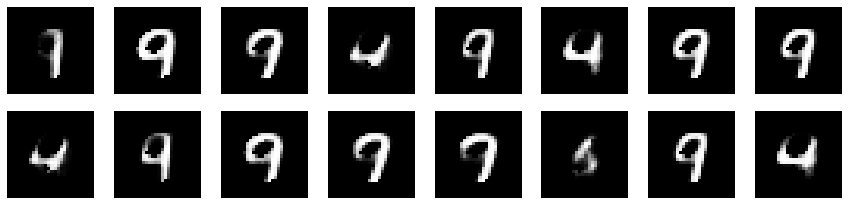

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

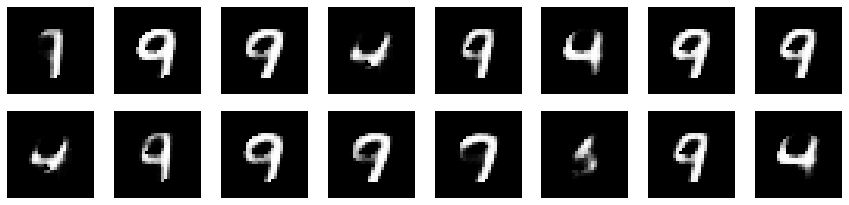

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

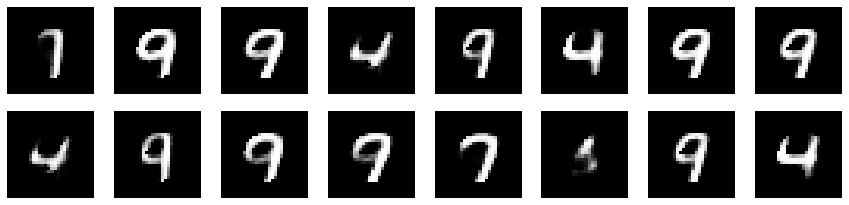

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

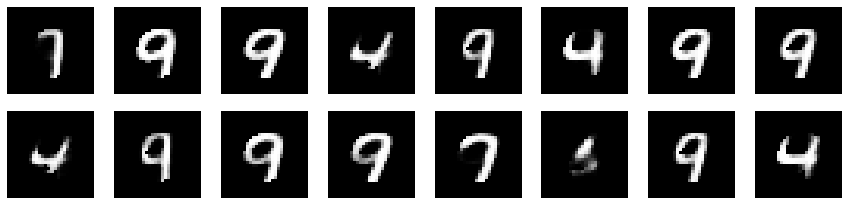

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

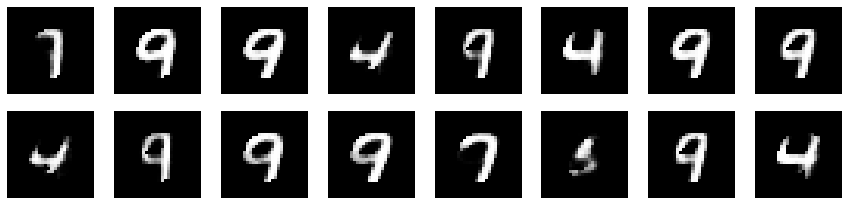

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

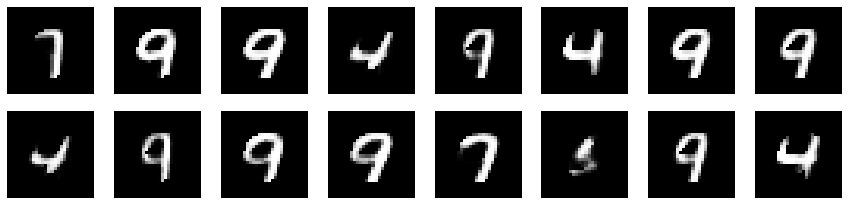

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

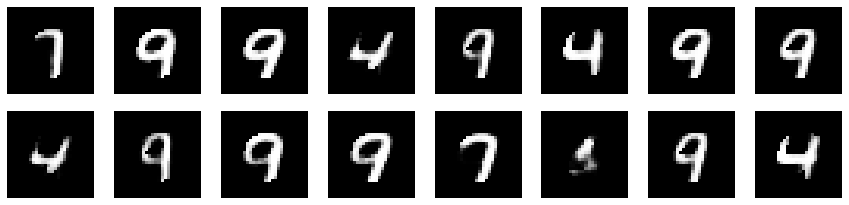

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

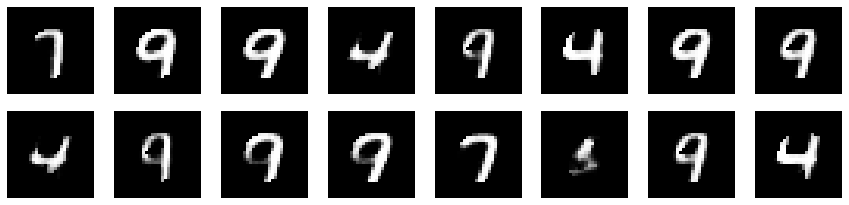

In [31]:
fixed_noise  = torch.rand(16, 2).to(device)

for epoch in range(NUM_EPOCHS):

    # model.train()
    loop = tqdm(train_loader,
            total=len(train_loader),
            leave=True)
    
    for x, _ in loop:
        
        real_labels = torch.ones([x.shape[0]]).to(device)
        fake_labels = torch.zeros([x.shape[0]]).to(device)
        fool_labels = real_labels

        #----
        # Reconstrcution phase
        #----

        # For our generator

        generator_optimizer.zero_grad()
        x_1d = x.reshape([-1, 1*28*28]).to(device)
        latent_var = encoder(x_1d)  
        x_pred = decoder(latent_var) 

        rc_loss = reconstruction_loss(x_pred, x_1d)  

        rc_loss.backward()
        generator_optimizer.step()

        #----
        # regularization phase, for our discriminator
        #---
        discriminator_optimizer.zero_grad()
        # sampling from true prior, real latent variables
        # consider it  comes from normal distribution then
        real_latent_var = torch.randn([x.shape[0], LATENT_DIM]).to(device)
        dis_true = discriminator(real_latent_var)

        # fake latent variables
        dis_fake = discriminator(latent_var.detach())

        dis_loss = 0.5 * (discriminator_loss(dis_true.reshape(-1), real_labels) 
        + discriminator_loss(dis_fake.reshape(-1), fake_labels))

        dis_loss.backward()
        discriminator_optimizer.step()

        # fool the discrminator
        generator_optimizer.zero_grad()
        latent_var = encoder(x_1d) 
        dis_fool = discriminator(latent_var)
        # fool_labels=real_labels
        fool_loss = discriminator_loss(dis_fool.reshape(-1), fool_labels)

        fool_loss.backward()
        # training the generator to produce latent that fools discriminator
        generator_optimizer.step()

        ## progress bar
        loop.set_description(f"Epoch [{epoch + 1}/{NUM_EPOCHS}]")
        loop.set_postfix(reconstruct_loss=rc_loss.item(), 
                         disc_loss=dis_loss.item(),
                         f_loss=fool_loss.item())

        # break
    """
    Checking on the fixed noise for each epoch
    """
    if epoch%5==0 or epoch==99:
        decoder.eval()
        with torch.no_grad():  
          # generating the images
            x_random = decoder(fixed_noise).detach()

        gen_x = x_random.reshape(16, 28, 28)
        # print(gen_x.shape)
        ax1 = show_grid_tensor(gen_x.cpu(), 16, c='gray')
        ax1.show()
    # break



## Looking at the encodings 

In [39]:
encoder.eval()  
x_test, label = next(iter(test_loader))

x_1d = x_test.reshape([-1, 1*28*28]).to(device)
encoded = encoder(x_1d)
encodings = encoded.to('cpu').detach().numpy()
labels = label.numpy()
for x_test, label in test_loader:
# x_test_d = x_test.
    x_1d = x_test.reshape([-1, 1*28*28]).to(device)
    encoded = encoder(x_1d)
    np_encoded = encoded.to('cpu').detach().numpy()
    encodings = np.concatenate((encodings, np_encoded), axis=0)
    labels = np.concatenate((labels, label), axis=0)
    # break
print(encodings.shape)
print(labels.shape)

(10064, 2)
(10064,)


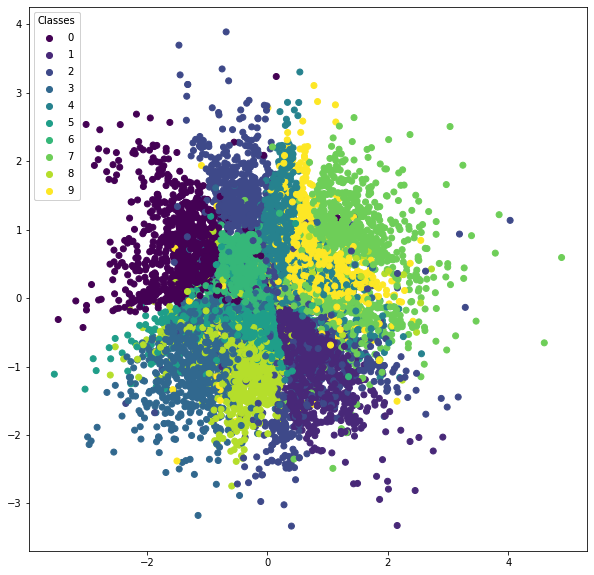

In [40]:
fig, ax = plt.subplots(figsize=(10,10))
scatter = ax.scatter(encodings[:,0], encodings[:,1], c=labels)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper left", title="Classes")
ax.add_artist(legend1)

plt.show()

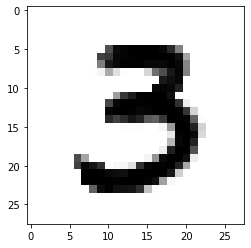

In [62]:
with torch.no_grad():
    new_image = decoder(torch.tensor([-2.0, -1.0]).to(device))
    # print(new_image.shape)

    # new_image.squeeze_(0)
    # new_image.squeeze_(0)
    new_image = new_image.reshape(28,28)
plt.imshow(new_image.to('cpu').numpy(), cmap='binary')
plt.show()